In [49]:
# import libraries
import pandas as pd
import geopandas as gpd 
import json 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import contextily as ctx
from shapely.geometry import LineString
from sklearn import metrics

## Programacion probisional del TRACLUS para el estudio

In [50]:
import importlib
import TRACLUS_3 as tr
importlib.reload(tr)
from sklearn.cluster import OPTICS

## Ejecuion del codigo y evaluacion

In [94]:
def cargar_datos(filename, nrows):
    # Cargar el archivo CSV
    df = pd.read_csv(filename, nrows=nrows)

    # Convertir las polilíneas de JSON a listas de coordenadas
    df['POLYLINE'] = df['POLYLINE'].apply(lambda x: json.loads(x) if pd.notnull(x) else None)

    # Filtrar filas con polilíneas vacías o nulas
    df = df[df['POLYLINE'].apply(lambda x: x is not None and len(x) > 0)]

    # Preparar las trayectorias para TRACLUS
    trayectorias = [np.array(polyline) for polyline in df['POLYLINE']]

    return trayectorias, df

In [52]:
def llamada_traclus(trayectorias, max_eps=None, min_samples=10, directional=True, use_segments=True, clustering_algorithm=OPTICS,):
    # Llamar a TRACLUS
    out = tr.traclus(trayectorias, max_eps, min_samples, directional, use_segments, clustering_algorithm)

    partitions, segments, dist_matrix, clusters, cluster_assignments, representative_trajectories = out

    counter1 = 0
    cluster_trayectories = []
    # Representacion de las trayectorias pero sin el primer elemento, este parece ser solo un conjunto basura
    representative_clusters = representative_trajectories[1:representative_trajectories.__len__()]

    # Trayectorias de los clusters en una lista pero sin el primer elemento
    for segment in clusters:
        if counter1 == 0:
            counter1 += 1
            continue
        else:
            counter1 += 1
        for part in segment:
            if isinstance(part, np.ndarray):    
                cluster_trayectories.append(part)

    return partitions, segments, dist_matrix, clusters, cluster_assignments, representative_trajectories, cluster_trayectories, representative_clusters

In [53]:
def plot_clusters_on_map(clusters, descart_minun_one=False, leyenda=False, output_file=None):
    # Crear un GeoDataFrame vacío
    gdf = gpd.GeoDataFrame(columns=['geometry', 'cluster_id'])

    cluster_id = 0
    # Añadir cada segmento al GeoDataFrame
    for segment in clusters:
        if descart_minun_one and cluster_id == 0:
            cluster_id +=1
            continue
        else:
            cluster_id +=1
        for part in segment:
            # Cada 'part' es un segmento dentro del cluster
            if isinstance(part, np.ndarray):  # Verificar si 'part' es un array de NumPy
                line = LineString(part)
                gdf = pd.concat([gdf, gpd.GeoDataFrame({'geometry': [line], 'cluster_id': [cluster_id]})], ignore_index=True)

    gdf.crs = "EPSG:4326"
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

    if not gdf.empty:
        # Generar colores para cada cluster
        unique_clusters = gdf['cluster_id'].unique()
        colormap = plt.cm.tab20
        color_dict = {cid: colormap(i / len(unique_clusters)) for i, cid in enumerate(unique_clusters)}

        # Dibujar cada segmento según su cluster_id
        for _, row in gdf.iterrows():
            color = color_dict[row['cluster_id']]
            gdf.loc[gdf.index == _, 'geometry'].plot(ax=ax, linewidth=2, color=color)

        # Añadir leyenda   
        if leyenda:     
            legend_elements = [Line2D([0], [0], color=color_dict[cid], lw=2, label=f'Cluster {cid}') for cid in unique_clusters]
            ax.legend(handles=legend_elements, loc='upper left')
        
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string())
    else:
        print("No hay datos válidos para graficar.")

    ax.set_axis_off()
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0.1)

In [54]:
def create_gdf(data):
    valid_geometries = [LineString(x) for x in data if len(x) > 1]
    gdf = gpd.GeoDataFrame(geometry=valid_geometries, crs='EPSG:4326')

    return gdf

In [137]:
def plot_map_colour(data, cmap='tab20' ,data2=None, cmap2='tab20', output_file=None):
    # Crear un GeoDataFrame
    gdf = create_gdf(data)
    if data2 is not None:
        gdf2 = create_gdf(data2)
    else:
        gdf2 = None

    # Visualizar en un mapa
    fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    if gdf2 is not None:
        gdf2.plot(ax=ax, cmap=cmap2, alpha=0.5, linewidth=1)
    gdf.plot(ax=ax, cmap=cmap, linewidth=2)

    # Añadir mapa base
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string())
    ax.set_axis_off()
    plt.savefig(output_file, bbox_inches='tight', pad_inches=0.1)

In [130]:
def plot_histogram1(cluster_assignments, clusters, output_file=None):
    len_cl = clusters.__len__()
    # Crear histograma de asignaciones de clusters
    plt.hist(cluster_assignments, bins=len_cl)
    plt.title("Histograma de asignaciones de clusters")
    plt.xlabel("Cluster")
    plt.ylabel("Frecuencia")
    plt.savefig(output_file)

    

In [131]:
def plot_histogram2(cluster_assignments, clusters, output_file=None):
    len_cl = clusters.__len__()
    cluster_asig_2 = [asig for asig in cluster_assignments if asig != -1]
    # Crear histograma de asignaciones de clusters
    plt.hist(cluster_asig_2, bins=len_cl)
    plt.title("Histograma de asignaciones de clusters")
    plt.xlabel("Cluster")
    plt.ylabel("Frecuencia")
    plt.savefig(output_file)

In [57]:
""" def plot_table(nombres_columnas, datos):
    # Longitud máxima para cada columna
    longitudes_maximas = [max(len(str(x)) for x in columna) for columna in zip(nombres_columnas, *datos)]

    # Imprimir la lista con nombres de columna y fila
    for nombre, longitud in zip(nombres_columnas, longitudes_maximas):
        print(f'{nombre.ljust(longitud)}', end=' ')
    print()
    for fila in datos:
        for elemento, longitud in zip(fila, longitudes_maximas):
            print(f'{str(elemento).ljust(longitud)}', end=' ')
        print() """

" def plot_table(nombres_columnas, datos):\n    # Longitud máxima para cada columna\n    longitudes_maximas = [max(len(str(x)) for x in columna) for columna in zip(nombres_columnas, *datos)]\n\n    # Imprimir la lista con nombres de columna y fila\n    for nombre, longitud in zip(nombres_columnas, longitudes_maximas):\n        print(f'{nombre.ljust(longitud)}', end=' ')\n    print()\n    for fila in datos:\n        for elemento, longitud in zip(fila, longitudes_maximas):\n            print(f'{str(elemento).ljust(longitud)}', end=' ')\n        print() "

In [112]:

def plot_table(nombres_columnas, datos, output_file=None):
    # Longitud máxima para cada columna
    longitudes_maximas = [max(len(str(x)) for x in columna) for columna in zip(nombres_columnas, *datos)]

    # Crear la figura y el eje de la tabla
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.axis('off')

    # Crear la tabla
    table = ax.table(cellText=datos, colLabels=nombres_columnas, cellLoc='center', loc='center')

    # Ajustar el tamaño de las celdas
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)

    # Guardar la tabla en un archivo PNG
    if output_file:
        plt.savefig(output_file, bbox_inches='tight', pad_inches=0.1)

In [142]:
def tabla_datos(trayectorias, partitions, segments, clusters, output_file=None):
    len_tr = trayectorias.__len__()
    len_par = partitions.__len__()
    len_seg = segments.__len__()
    len_cl = clusters.__len__()

    # Lista de nombres de columnas
    nombres_columnas = ["", "Trayectorias", "Particiones", "Segmentos", "Clusters"]

    # Lista de datos
    datos = [
        ["Tamaño:" ,len_tr, len_par, len_seg, len_cl],
        ["Cantidad/t:", len_tr/len_tr, len_par/len_tr, len_seg/len_tr, len_cl/len_tr],
    ]

    plot_table(nombres_columnas, datos, output_file)
    


In [143]:
def tabla_relacional(df, segments, cluster_assignments, output_file=None):
    # Temporary list to store data before creating GeoDataFrame
    gdf_stc_data = []
    index = 0

    for segment, cluster_id in zip(segments, cluster_assignments):
        if isinstance(segment, np.ndarray):
            line = LineString(segment)
            tray_id_found = False
            
            for i, polyline in enumerate(df['POLYLINE'][index:len(df['POLYLINE'])]):
                # Check if the polyline has 2 or more points
                if i > 0:
                    index += 1

                if len(polyline) >= 2:
                    tray_line = LineString(polyline)
                    
                    if tray_line.intersects(line):
                        tray_id = index
                        tray_id_found = True
                        break  # Exit the loop once a matching tray_line is found
                else:
                    continue  # Skip this polyline as it cannot form a valid LineString

            if not tray_id_found:
                tray_id = -1  # Indicator for 'not found'

            # Append valid data to the list
            gdf_stc_data.append({'geometry': line, 'cluster_id': cluster_id, 'tray_id': tray_id})

    # Create the GeoDataFrame from the collected data
    gdf_stc = gpd.GeoDataFrame(gdf_stc_data, columns=['geometry', 'cluster_id', 'tray_id'])

    gdf_stc.to_csv(output_file, index=False)


In [144]:
def save_clustering_metrics_to_csv(dist_matrix, cluster_assignments, output_file='clustering_metrics.csv'):
    """
    Calcula métricas para evaluar la calidad del clustering y las guarda en un archivo CSV.

    :param dist_matrix: Matriz de distancias entre los puntos o segmentos.
    :param cluster_assignments: Asignaciones de cluster para cada punto o segmento.
    :param output_file: Ruta del archivo CSV donde se guardarán las métricas.
    """
    metrics_dict = {}

    # Calcular Silhouette Score
    unique_clusters = np.unique(cluster_assignments)
    if len(unique_clusters) > 1 and len(unique_clusters) < len(cluster_assignments) - 1:
        metrics_dict['silhouette_score'] = metrics.silhouette_score(dist_matrix, cluster_assignments, metric='precomputed')
    else:
        metrics_dict['silhouette_score'] = 'No aplicable'

    # Inicializar listas para distancias
    intra_cluster_distances = []
    inter_cluster_distances = []

    # Calcular distancias intra e inter cluster
    for i, center in enumerate(unique_clusters):
        # Distancias intra-cluster
        intra_points_indices = np.where(cluster_assignments == center)[0]
        if len(intra_points_indices) > 1:  # Evitar calcular en clusters con un solo punto
            intra_cluster_distances.append(np.mean(dist_matrix[intra_points_indices][:, intra_points_indices]))

        # Distancias inter-cluster
        for other_center in unique_clusters[i + 1:]:
            inter_points_indices = np.where(cluster_assignments == other_center)[0]
            if len(inter_points_indices) > 0:  # Evitar clusters vacíos
                inter_cluster_distances.append(np.mean(dist_matrix[intra_points_indices][:, inter_points_indices]))

    # Añadir resultados al diccionario
    metrics_dict['average_intra_cluster_distance'] = np.mean(intra_cluster_distances) if intra_cluster_distances else 'No aplicable'
    metrics_dict['average_inter_cluster_distance'] = np.mean(inter_cluster_distances) if inter_cluster_distances else 'No aplicable'

    # Guardar las métricas en un archivo CSV
    metrics_df = pd.DataFrame([metrics_dict])
    metrics_df.to_csv(output_file, index=False)

## Ejecucion del TRACLUS

In [62]:
# Variables globales
nrows = 200
# Ruta del archivo CSV
filename = "C:/Users/Álvaro/Documents/GitHub/TFG/TFG_TRACLUS/app/train_data/taxis_trajectory/train.csv"

In [95]:
gdf, df = cargar_datos(filename, nrows)

In [77]:
out = llamada_traclus(gdf, max_eps=None, min_samples=5, clustering_algorithm=OPTICS)

c:\Users\Álvaro\Documents\GitHub\TFG\TFG_TRACLUS\app\src\Estudio\TRACLUS_3.py:332: RuntimeWarning: divide by zero encountered in scalar divide
  else:
c:\Users\Álvaro\Documents\GitHub\TFG\TFG_TRACLUS\app\src\Estudio\TRACLUS_3.py:630: UserWarning: WARNING: No representative points were found.
  # Early return if there are no representative points


In [134]:
output_file_clustermap = "C:/Users/Álvaro/Documents/GitHub/TFG/TFG_TRACLUS/app/src/EStudio/OPTICS/clusters_map.png"
output_file_colormap = "C:/Users/Álvaro/Documents/GitHub/TFG/TFG_TRACLUS/app/src/EStudio/OPTICS/clusters_map_colour.png"
output_file_histogram1 = "C:/Users/Álvaro/Documents/GitHub/TFG/TFG_TRACLUS/app/src/EStudio/OPTICS/histogram1.png"
output_file_histogram2 = "C:/Users/Álvaro/Documents/GitHub/TFG/TFG_TRACLUS/app/src/EStudio/OPTICS/histogram2.png"
output_file_table = "C:/Users/Álvaro/Documents/GitHub/TFG/TFG_TRACLUS/app/src/EStudio/OPTICS/table.png"
output_file_table_relacional = "C:/Users/Álvaro/Documents/GitHub/TFG/TFG_TRACLUS/app/src/EStudio/OPTICS/table_relacional.csv"
output_file_metrics = "C:/Users/Álvaro/Documents/GitHub/TFG/TFG_TRACLUS/app/src/EStudio/OPTICS/clustering_metrics.csv"

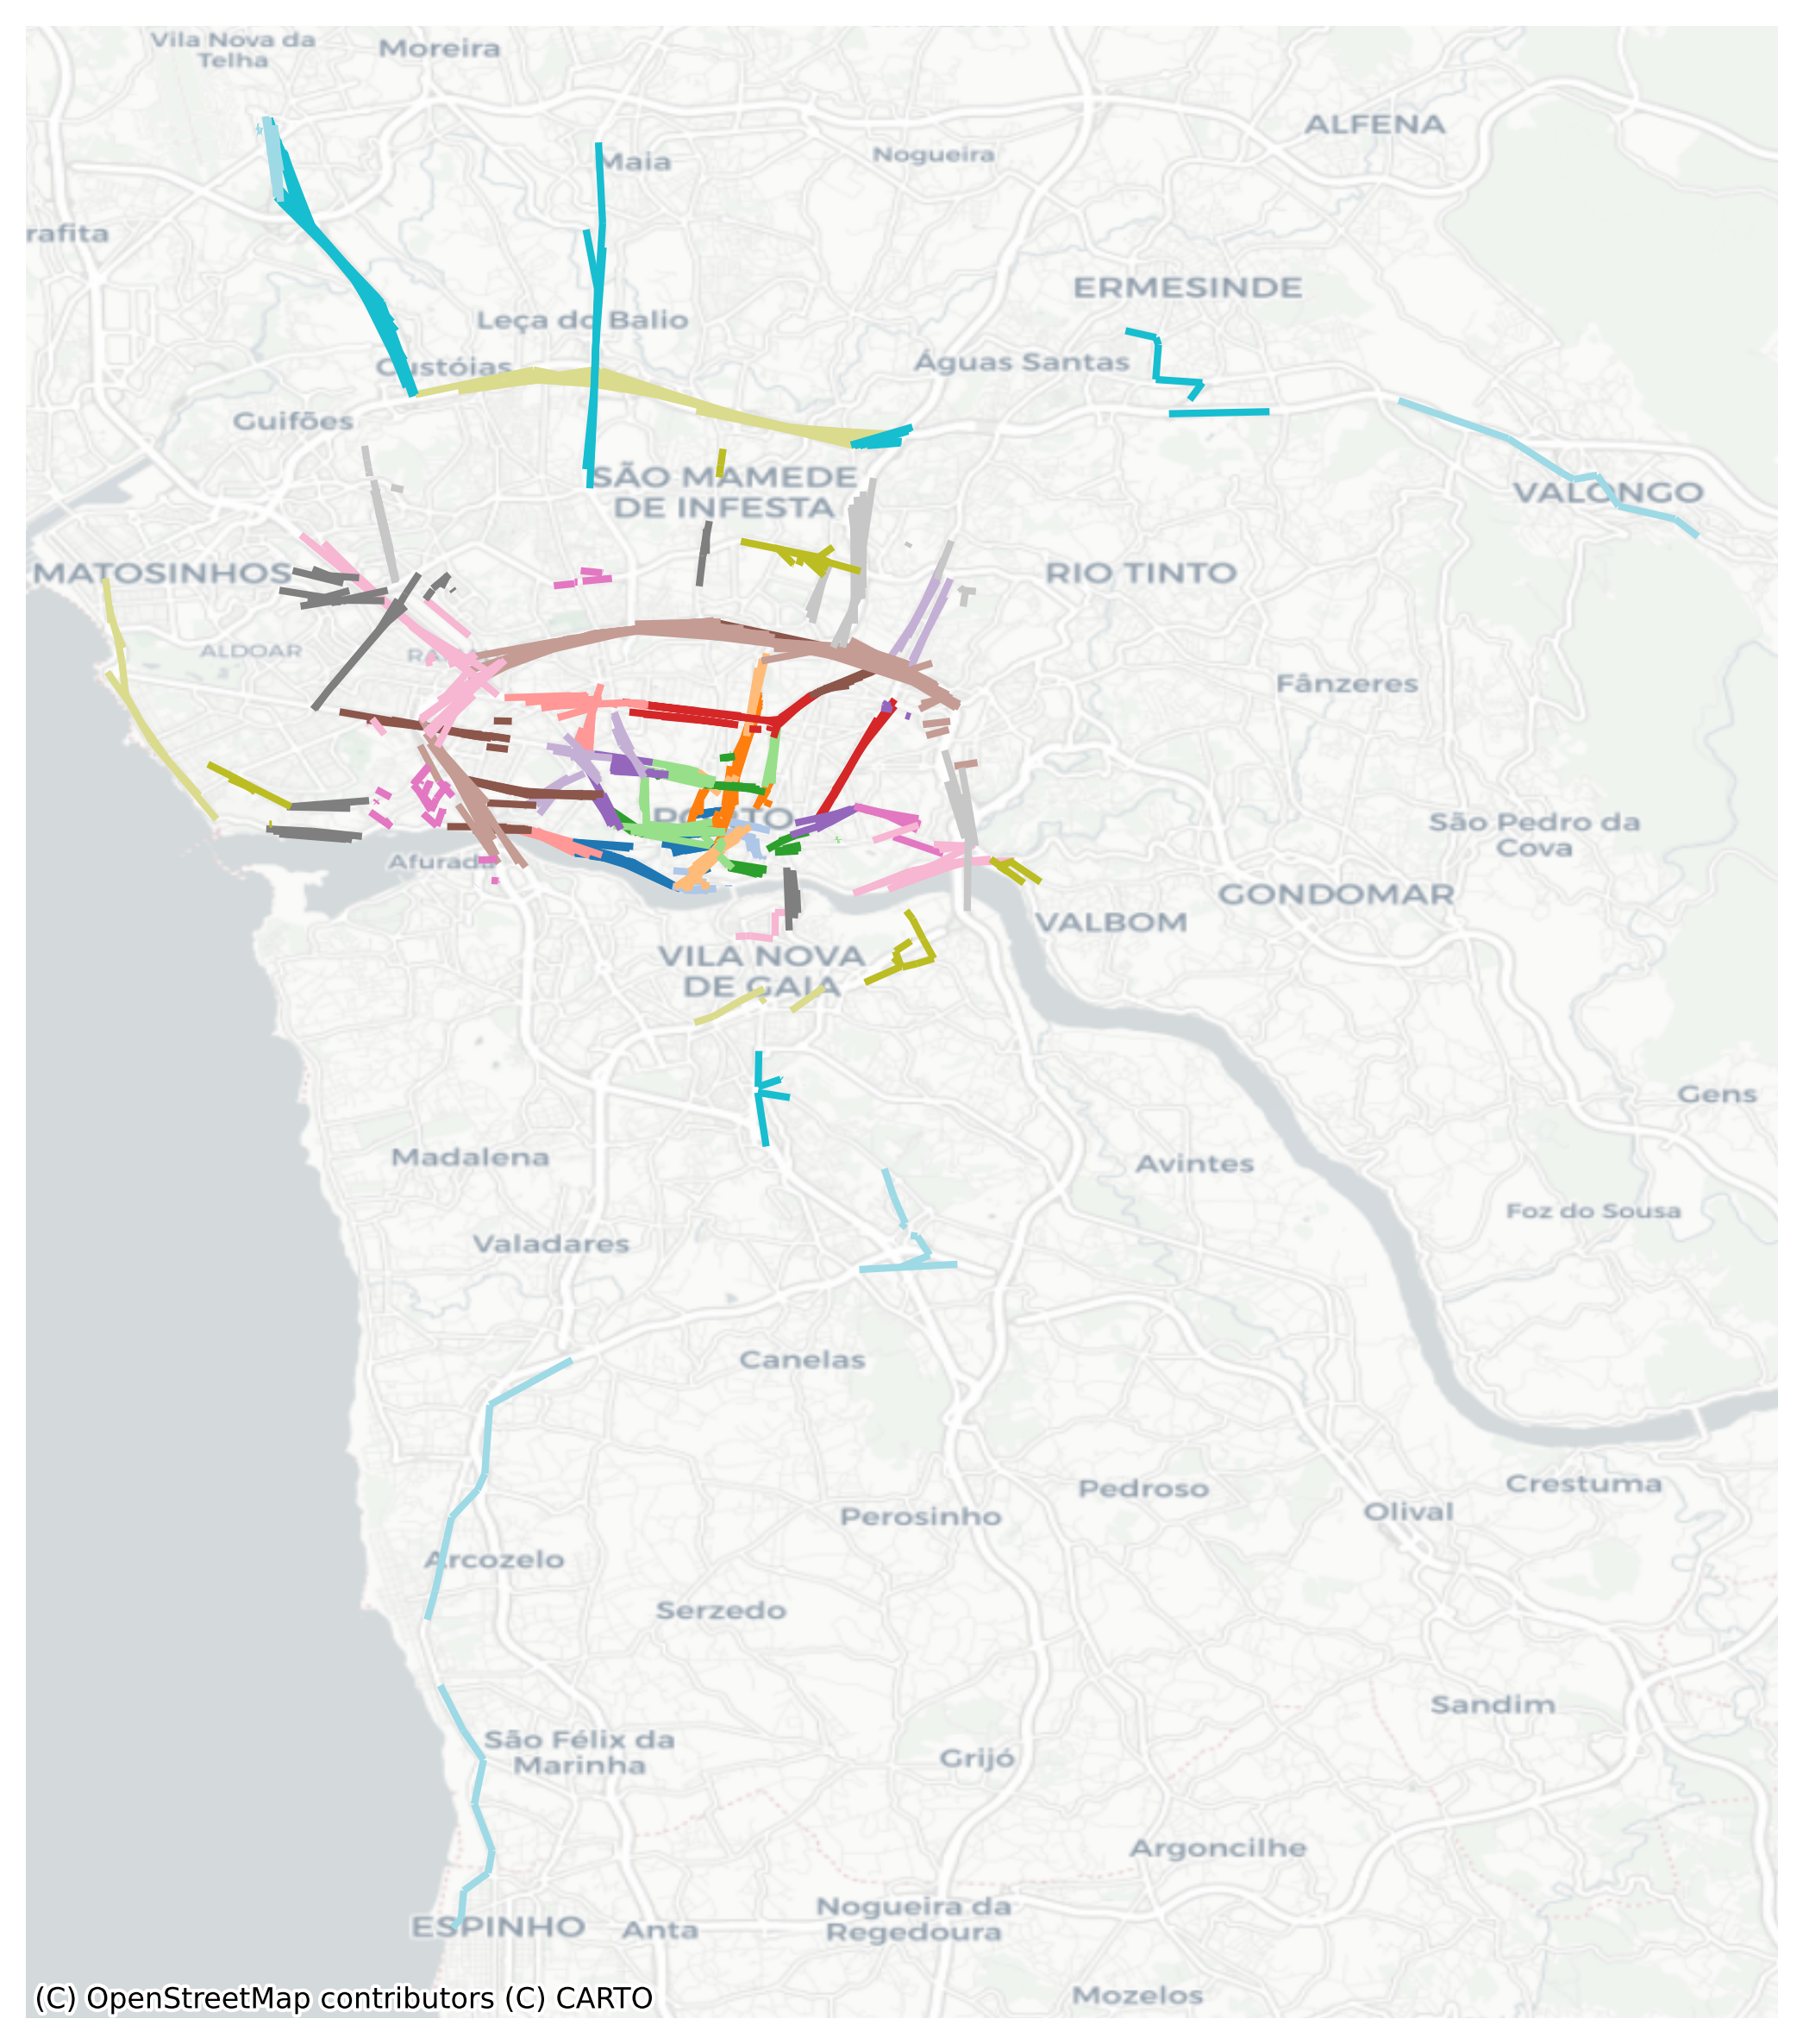

In [135]:
plot_clusters_on_map(out[3], descart_minun_one=True, savefile=output_file_clustermap)

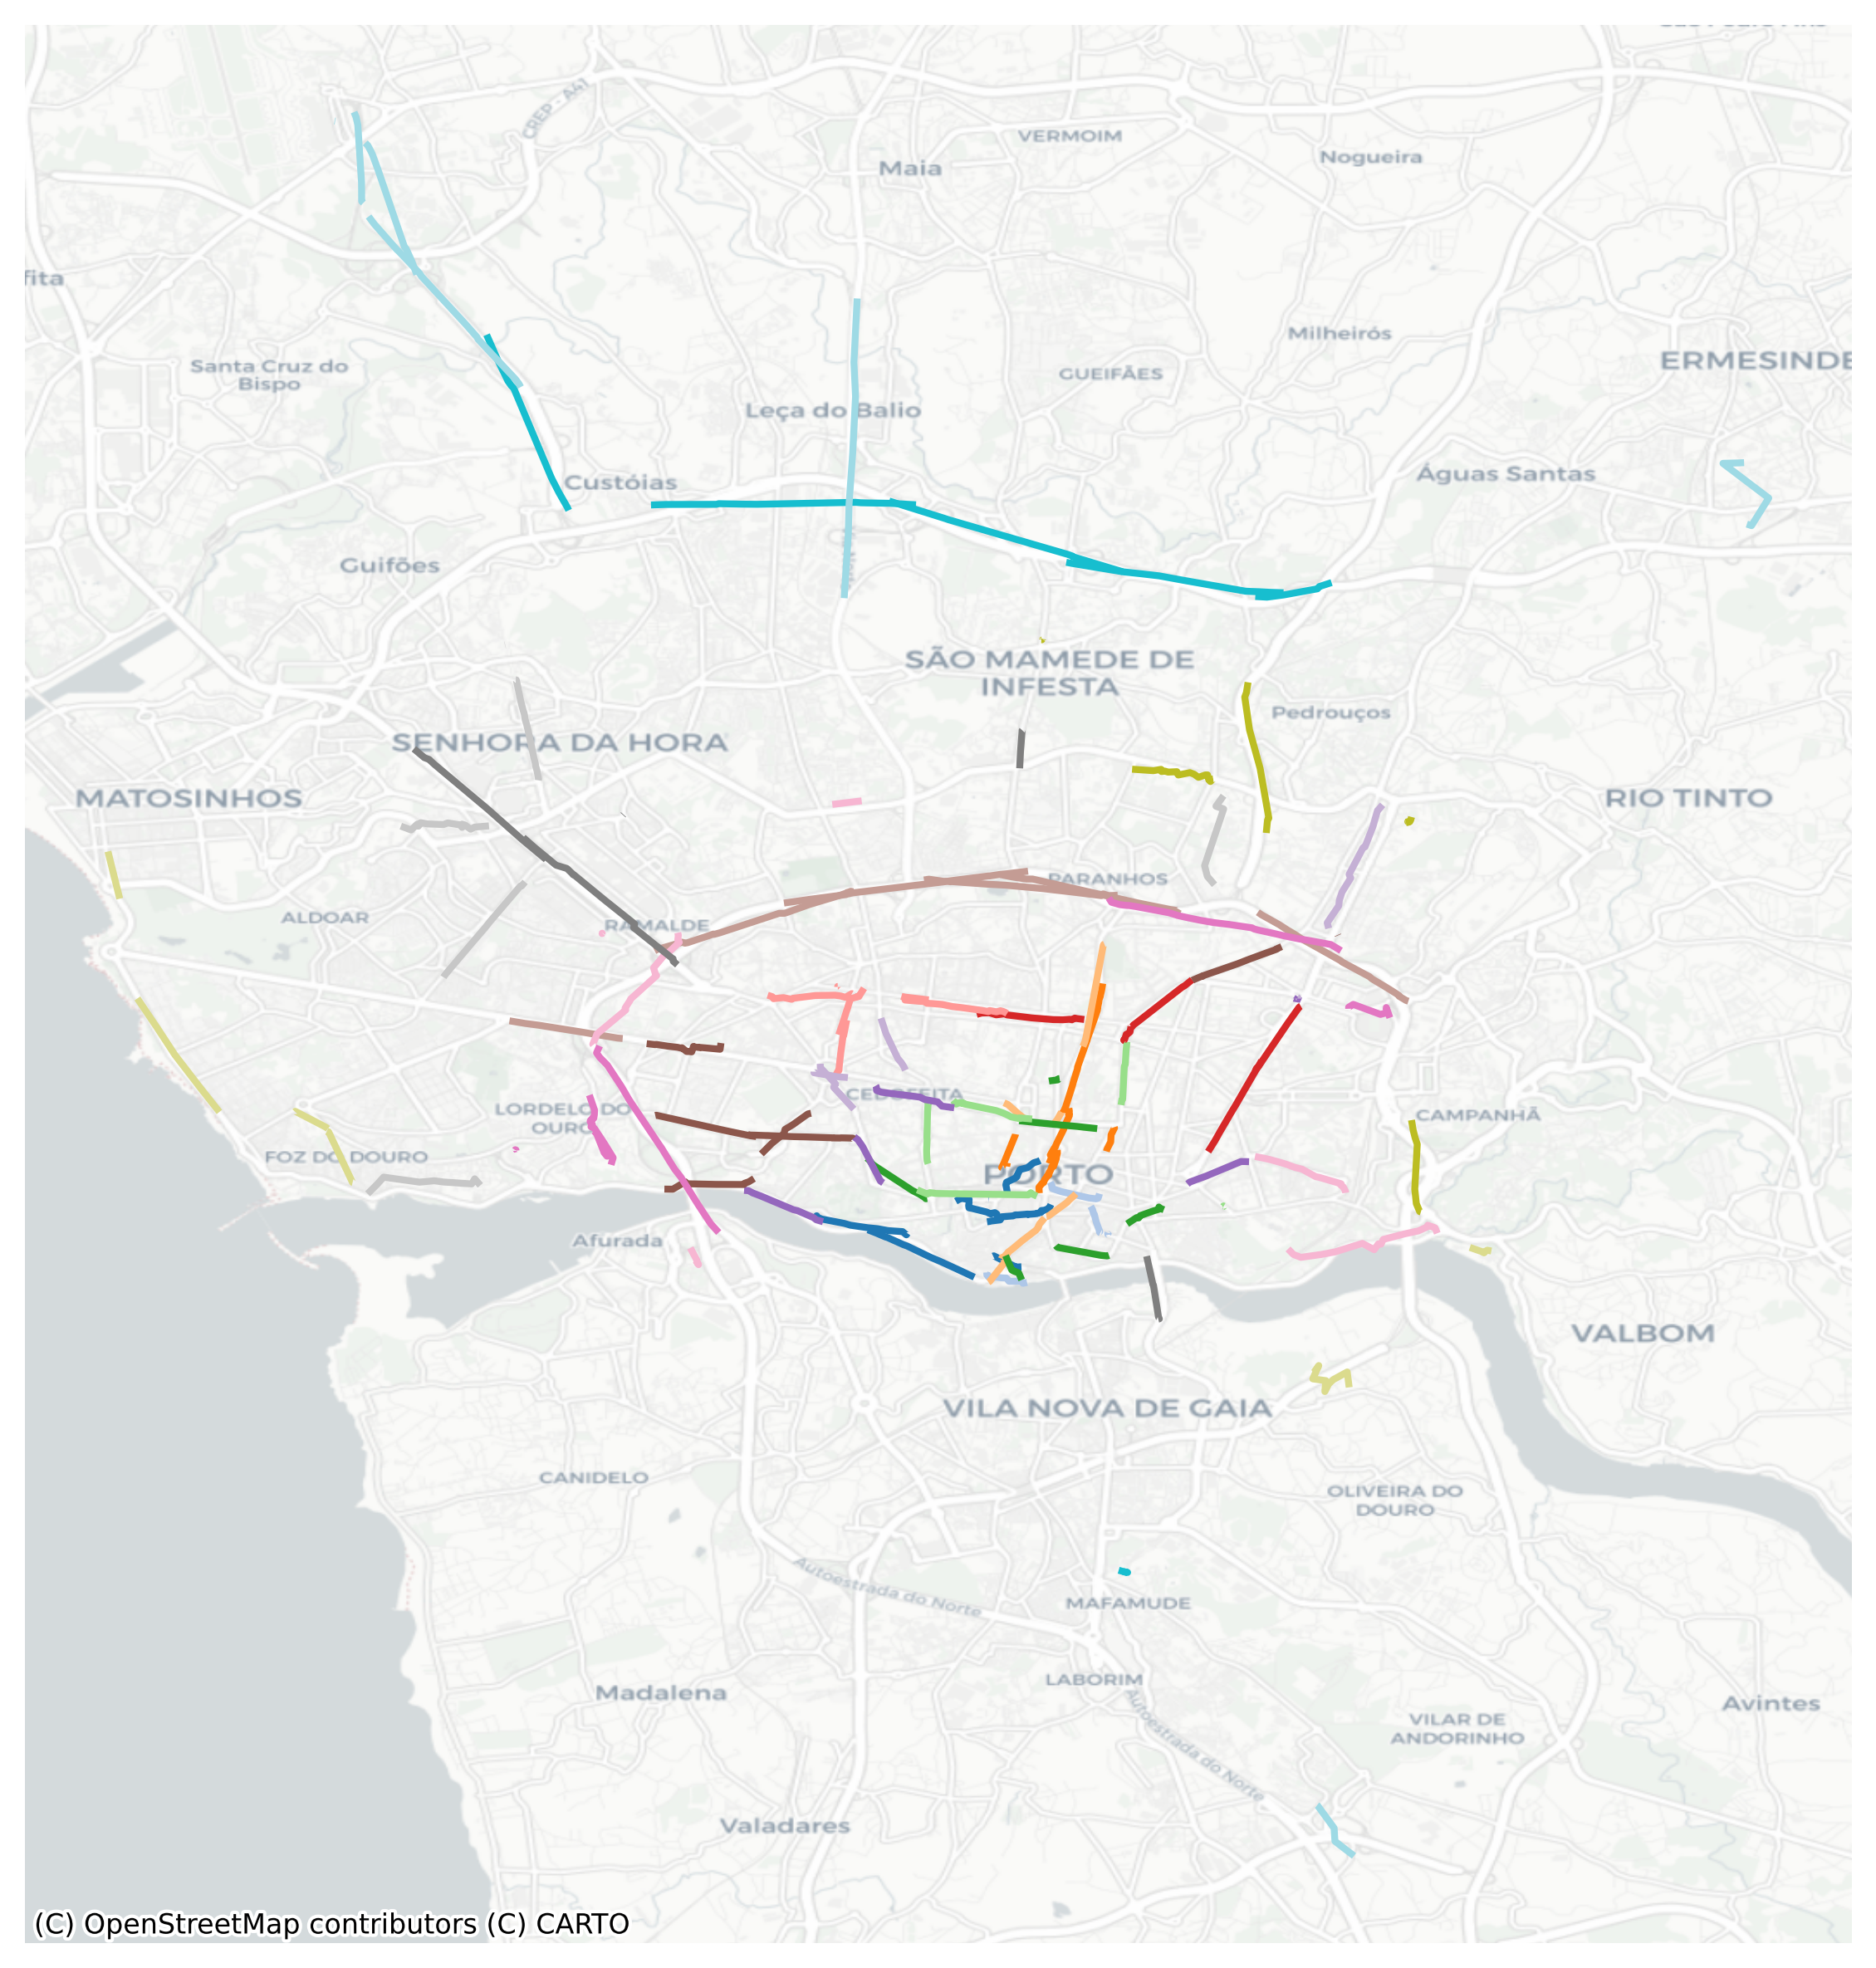

In [138]:
plot_map_colour(out[7], output_file=output_file_colormap)

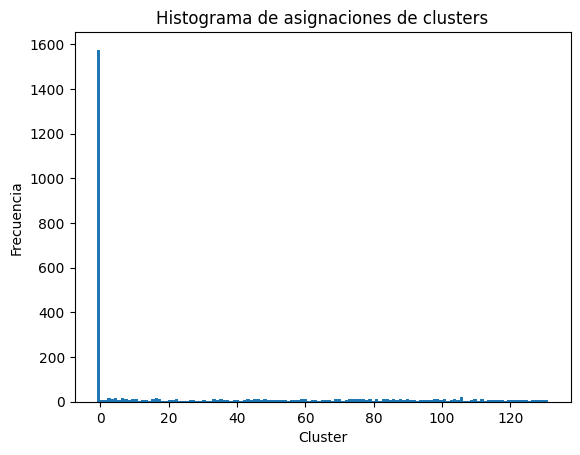

In [139]:
plot_histogram1(out[4], out[3], output_file=output_file_histogram1)

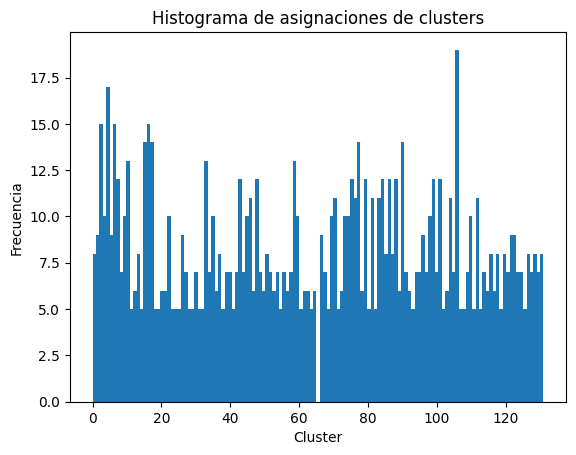

In [140]:
plot_histogram2(out[4], out[3], output_file=output_file_histogram2)

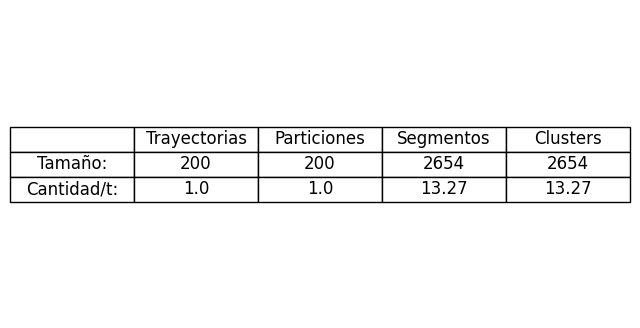

In [145]:
tabla_datos(gdf, out[0], out[1], out[2], output_file=output_file_table)

In [146]:
tabla_relacional(df, out[1], out[4], output_file=output_file_table_relacional)

In [147]:
save_clustering_metrics_to_csv(out[2], out[4], output_file=output_file_metrics)